# Evaluation
CMP5101 notes (Tevfik Aytekin)

Below are some commonly used metrics for evaluating the performance of regression and classification methods. Note that there are many other metrics which can be used for evaluation. There is no best metric, instead every metric some set of properties and should be used according to the specific needs of the user.

## Metrics for Regression

#### Mean Absolute Error (MAE)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Properties:
- Can be used for regression problems

#### Mean Squared Error (MSE)

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

Properties:
- Can be used for regression problems
- Penalizes large errors more compared to MAE. So, more sensitive to outliers than MAE

#### Root Mean Squared Error (RMSE)

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Properties:
- Similar to MSE but scales the error back to the scale of the target values.
- Since square root is a nondecreasing function, if a result $a$ is better than $b$ with respect to MSE than $a$ is also better than $b$ with respect to RMSE.

#### The Coefficient of Determination, r-squared ($r^2$)

$$ r^2 = 1 - \frac{MSE_{model}}{MSE_{mean}}$$ 

where $MSE_{mean}$ is the MSE of the baseline model which always predicts the mean of the target values in the training set.

Properties:
- Evaluates the performance of your model with respect to a baseline.

#### Mean Percentage Absolute Error (MAPE)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_i - \hat{y}_i}{y_i}\right|*100$$

Properties:
- Gives a scaled error value independent of the magnitude of the target values.
- Problematic when the target value is 0 or very close to 0.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
train = pd.read_csv("house-prices/train.csv")
X = train[['GrLivArea']]
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
model_slr = linear_model.LinearRegression()
model = model_slr.fit(X_train, y_train)
train_predictions = model_slr.predict(X_train)
test_predictions = model_slr.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, test_predictions))
print("Test MSE:", mean_squared_error(y_test, test_predictions))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_predictions)))
print("Test r-squared:", r2_score(y_test, test_predictions))
print("Test MAPE:",np.mean(np.abs((y_test - test_predictions) / y_test)) * 100);

Test MAE: 36268.059505596946
Test MSE: 2462129256.3018956
Test RMSE: 49619.84740304927
Test r-squared: 0.5203311755432714
Test MAPE: 20.414733708941228


## Metrics for Classification

#### Confusion Matrix
<img src="images/confusion_matrix.png" style="max-width:100%; width: 40%">

- TP: the number of cases where both actual and predicted values are positive
- FN: the number of cases where actual value is positive but predicted value is negative
- FP: the number of cases where actual value is negative but predicted value is positive
- TN: the number of cases where both actual and predicted values are negative


#### Accuracy
$$ Accuracy = \frac{TP+TN}{TP+FN+FP+TN}$$

#### Precision
$$ Precision = \frac{TP}{TP+FP}$$

#### Recall
$$ Recall = \frac{TP}{TP+FN}$$

#### F-measure
$$ F_1 = \frac{2*Precision*Recall}{Precision+Recall}$$

#### Kappa

$$ \kappa = \frac{p_a-p_e}{1-p_e}$$

where $p_a$ is the accuracy of the model and $p_e$ is the expected accuracy of pure chance.

#### ROC Curve and AUC

ROC Curves can be used to evaluate the performance of a classifier which produces a probabilistic output for class membership. When the classifier produces a probabilistic output, you have the chance to put a threshold for class membership. ROC curve is generated by moving the threshold to different values and find the true positive rate (tpr) and false positive rate (fpr) at these thresholds. Area under the curve (AUC) is the total area under the ROC curve. Classifiers whose AUC is larger are better classifiers.

$$
True \: Positive\: Rate\:(TPR) = Recall = \frac{TP}{TP+FN}
$$

$$
False\: Positive\: Rate\:(FPR) = \frac{FP}{FP+TN}
$$


In [2]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'gender', 'cp', 'trestbps', 'chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','diagnosis']
heart = pd.read_csv(url, names=names, na_values=["?"])
heart.head(5)

,age,gender,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split  

X = heart.iloc[:,0:12]
y = heart.iloc[:,13]
y = y.replace([1,2,3,4],[1,1,1,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=3)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = KNeighborsClassifier(n_neighbors=10)
clf2 = DecisionTreeClassifier(min_samples_split=20)
clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);
y_pred1 = clf1.predict_proba(X_test)  
y_pred2 = clf2.predict_proba(X_test)  

The table below shows the probabilities of being a positive example produced by KNN and DTree models. Given these results which model is better? 

In [4]:
# Class values and predicted class probabilities, thresholds, tpr, fpr
pd.options.display.float_format = '{:,.1f}'.format
pd.DataFrame([y_test.values, 
                y_pred1[:, 1],
                y_pred2[:, 1]],
                index = ['Actual Class','Prob (KNN)','Prob (DTree)'])

,0,1,2,3,4,5,6,7,8,9
Actual Class,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Prob (KNN),0.7,0.4,0.8,0.4,0.6,0.3,0.2,0.5,0.3,0.5
Prob (DTree),0.1,0.0,0.0,0.8,1.0,0.0,0.0,0.5,0.0,0.1


The difficulty with evaluating classifiers which produce probabilistic output lies in the fact that there are many possible thredholds we can use. And for every threshold the precision and recall values can change. One way to solve this problem is to calculate precision and recall values for every possible threshold and get a overall result. ROC curves do exactly this.

In [5]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1[:, 1],drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2[:, 1],drop_intermediate=False)

In [6]:
import matplotlib.pyplot as plt

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.plot(fpr1,tpr1,label='K-NN ROC curve (AUC = %0.2f)' % auc1);
plt.plot(fpr2,tpr2,label='DTree ROC curve (AUC = %0.2f)' % auc2);
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0, 0.5, 'True Positive Rate')

According to the above figure, DTree is a better classifier than K-NN since its AUC value is larger. AUC is a measure for comparing the performance of classifiers which produce probabilities for class membership. It is a way to sum up the performance of a classifier for all possible thresholds.

One approach to understanding ROC curves is to look at how they are drawn: Start the threshold at the lowest value, that corresponds to point (1,1) at the ROC curve. As you increase the threshold, every false negative decreases the curve one level down otherwise curve moves to the left.

In [7]:
# Class values and sorted predicted class probabilities
pd.DataFrame([y_test.values, 
                  y_pred1[:, 1]],
                 index = ['Class','Prob (K-NN)']).sort_values(axis=1, by='Prob (K-NN)')

,6,5,8,1,3,7,9,4,0,2
Class,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
Prob (K-NN),0.2,0.3,0.3,0.4,0.4,0.5,0.5,0.6,0.7,0.8


In [8]:
# thresholds, tpr, fpr
pd.DataFrame([thresholds1[::-1], 
                  tpr1[::-1],
                   fpr1[::-1]],
                 index = ['Thresholds','TPR', 'FPR'])

,0,1,2,3,4,5,6,7
Thresholds,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.8
TPR,1.0,0.9,0.7,0.6,0.3,0.1,0.0,0.0
FPR,1.0,1.0,0.7,0.3,0.3,0.3,0.3,0.0


Below illustrates the two extreme cases: 

Text(0, 0.5, 'True Positive Rate')

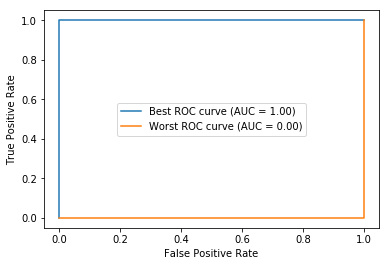

In [9]:
y_test = [0,0,0,0,0,1,1,1,1,1]
y_pred1 = [0.15,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72]
y_pred2 = list(reversed(y_pred1))
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1,drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2,drop_intermediate=False)

# Seems to be a bug in sklearn, even though in the documentation it says that 
# thresholds[0] is set to max(y_score) + 1, it is not. So, the following two 
# lines are needed to start the ROC curve at (0,0).
tpr1 = np.r_[0, tpr1] 
fpr1 = np.r_[0, fpr1] 

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.plot(fpr1,tpr1,label='Best ROC curve (AUC = %0.2f)' % auc1);
plt.plot(fpr2,tpr2,label='Worst ROC curve (AUC = %0.2f)' % auc2);
plt.legend(loc="center")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [10]:
thresholds1

array([1.92, 0.92, 0.88, 0.72, 0.68, 0.62, 0.2 , 0.18, 0.15, 0.12, 0.1 ])

Also compare the following cases, which one is a better classifier? In the test set there are 5 positive (green color) and 5 negative (blue color) examples. The arrays show the examples as sorted by predicted probabilities.

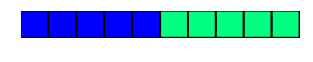

In [11]:
# Case 1
y_test = np.array([0,0,0,0,0,1,1,1,1,1])
y_pred1 = np.array([0.15,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred1.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

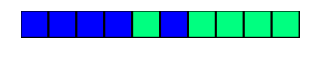

In [12]:
# Case 2
y_pred2 = np.array([0.63,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred2.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

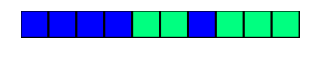

In [13]:
# Case 3
y_pred3 = np.array([0.69,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred3.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

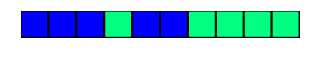

In [14]:
# Case 4
y_pred4 = np.array([0.66,0.1,0.2,0.67,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred4.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

In general the more blue's to the left the better the classifier. AUC score makes this vague characterization precise.

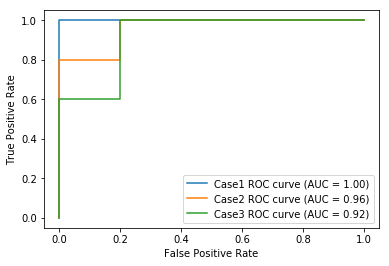

In [15]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1,drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2,drop_intermediate=False)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred3,drop_intermediate=False)


auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)

plt.plot(fpr1,tpr1,label='Case1 ROC curve (AUC = %0.2f)' % auc1);
plt.plot(fpr2,tpr2,label='Case2 ROC curve (AUC = %0.2f)' % auc2);
plt.plot(fpr3,tpr3,label='Case3 ROC curve (AUC = %0.2f)' % auc3);

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

One approach to understanding ROC curves is to look at how they are drawn: Start the threshold at the lowest value, that corresponds to point (1,1) at the ROC curve. As you increase the threshold, any every false negative decreases the curve one level down otherwise curve moves to the left. 

<b>Question 1</b>: Can there be two different sequences of positive and negative examples such that their AUC values is the same?

<b>Question 2</b>: What are the disadvantages of ROC-curves? One disadvantage is false positives and false negative have the same misclassification costs, but in reality they can be different.

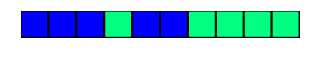

In [16]:
# Case 4
y_pred4 = np.array([0.66,0.1,0.2,0.67,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred4.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

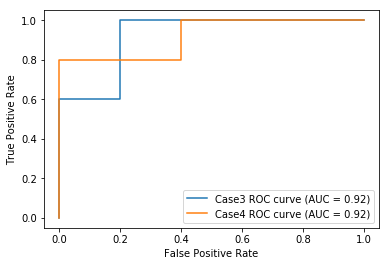

In [17]:
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred4,drop_intermediate=False)

auc4 = auc(fpr4, tpr4)

plt.plot(fpr3,tpr3,label='Case3 ROC curve (AUC = %0.2f)' % auc3);
plt.plot(fpr4,tpr4,label='Case4 ROC curve (AUC = %0.2f)' % auc4);

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

Text(0, 0.5, 'True Positive Rate')

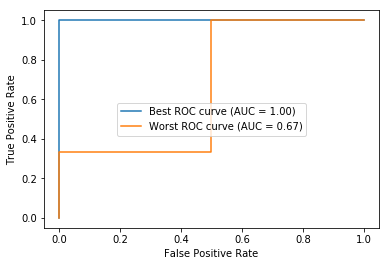

In [19]:
y_test = [1,0,1,0,1]
y_pred1 = [0.85,0.16,0.35,0.21,0.55]
y_pred2 = [0.76, 0.63, 0.27, 0.15, 0.23]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1,drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2,drop_intermediate=False)

# Seems to be a bug in sklearn, even though in the documentation it says that 
# thresholds[0] is set to max(y_score) + 1, it is not. So, the following two 
# lines are needed to start the ROC curve at (0,0).
tpr1 = np.r_[0, tpr1] 
fpr1 = np.r_[0, fpr1] 

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.plot(fpr1,tpr1,label='Best ROC curve (AUC = %0.2f)' % auc1);
plt.plot(fpr2,tpr2,label='Worst ROC curve (AUC = %0.2f)' % auc2);
plt.legend(loc="center")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')